In [31]:
import matplotlib.pyplot as plt
from scipy.constants import sigma
from scipy.optimize import minimize
import os
import pandas as pd
import cvxpy as cp
import numpy as np
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV


from portfolio_utils import load_datas, f_returns_on_df, f_mu_on_df, f_sigma_on_df
from level2.functions import optimize

# Charger les données
df = load_datas()

In [21]:
# Calcul des rendements logarithmiques
returns = f_returns_on_df(df)

# Calcul des paramètres pour l'optimisation
mu = f_mu_on_df(returns)  # Annualisation (252 jours boursiers)
Sigma = f_sigma_on_df(returns)  # Annualisation de la matrice de covariance
num_assets = len(mu)


In [22]:
c = 0.001  # Coût proportionnel de transaction
w0 = np.array(num_assets * [0])  # Portefeuille
#w0[0] = 0.5  # 50% dans le premier actif
#w0[1] = 0.3  # 30% dans le deuxième actif
w0[2] = 1  # 20% dans le troisième actif

K = 10  # Nombre d'actifs à sélectionner

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Récupérer les portefeuilles réparés valides
frontier_yields, frontier_volatility, frontier_cost, frontier_weights = optimize(mu, Sigma, w0, K, delta_tol=0.01, population_size=300, generations=1000, c=c)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      300 |     12 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      600 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0759569417 |         ideal
     3 |      900 |     25 |  0.000000E+00 |  0.000000E+00 |  0.1341741665 |         ideal
     4 |     1200 |     30 |  0.000000E+00 |  0.000000E+00 |  0.1183338225 |         ideal
     5 |     1500 |     35 |  0.000000E+00 |  0.000000E+00 |  0.1263178707 |         ideal
     6 |     1800 |     39 |  0.000000E+00 |  0.000000E+00 |  0.3803637585 |         ideal
     7 |     2100 |     36 |  0.000000E+00 |  0.000000E+00 |  0.0294368941 |         ideal
     8 |     2400 |     53 |  0.000000E+00 |  0.000000E+00 |  0.0249490684 |         ideal
     9 |     2700 |     57 |  0.000000E+00 |  0.000000E+00 |  0.0819728357 |         ideal
    10 |     3000 |     73 |  0.000000E+00 |  0.000000E+00 |  0.1333220973 |         ideal

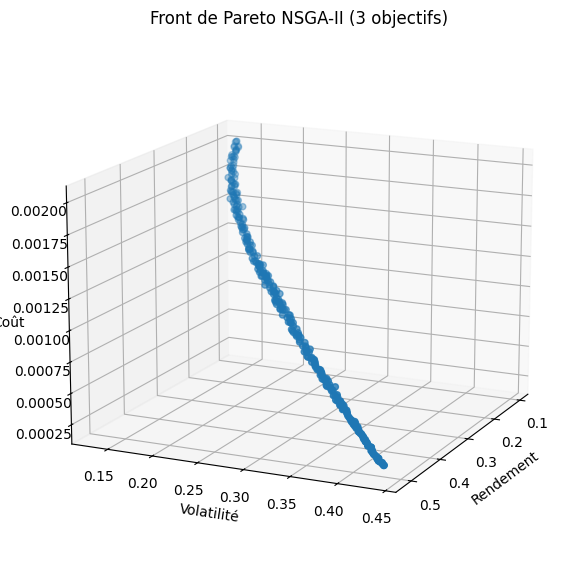

In [24]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=15, azim=25)

ax.scatter(frontier_yields, frontier_volatility, frontier_cost)

ax.set_xlabel('Rendement')
ax.set_ylabel('Volatilité')
ax.set_zlabel('Coût')

plt.title("Front de Pareto NSGA-II (3 objectifs)")
plt.show()

In [25]:
# Max rendement
max_return_index = np.argmax(frontier_yields)
w_max = frontier_weights[max_return_index]
print(f"Portefeuille avec rendement maximal (exact {K} actifs) :")
print(f"Rendement : {frontier_yields[max_return_index]:.4f}")
print(f"Volatilité : {frontier_volatility[max_return_index]:.4f}")
print(f"Coût : {frontier_cost[max_return_index]:.4f}")
for i, weight in enumerate(w_max):
    if weight > 1e-4:
        print(f"  {df.columns[i]} : {weight:.4f}")

# Min volatilité
min_vol_index = np.argmin(frontier_volatility)
w_min = frontier_weights[min_vol_index]
print(f"\nPortefeuille avec risque minimal (exact {K} actifs) :")
print(f"Rendement : {frontier_yields[min_vol_index]:.4f}")
print(f"Volatilité : {frontier_volatility[min_vol_index]:.4f}")
print(f"Coût : {frontier_cost[min_vol_index]:.4f}")
for i, weight in enumerate(w_min):
    if weight > 1e-4:
        print(f"  {df.columns[i]} : {weight:.4f}")

Portefeuille avec rendement maximal (exact 10 actifs) :
Rendement : 0.5203
Volatilité : 0.4384
Coût : 0.0002
  NVDA : 0.8872
  NFLX : 0.0119
  TMUS : 0.0122
  TGT : 0.0163
  COST : 0.0134
  ABBV : 0.0106
  LLY : 0.0124
  ETN : 0.0126
  SO : 0.0109
  XEL : 0.0126

Portefeuille avec risque minimal (exact 10 actifs) :
Rendement : 0.0981
Volatilité : 0.1318
Coût : 0.0020
  TSM : 0.0569
  VZ : 0.1756
  MCD : 0.0831
  HLT : 0.0725
  WMT : 0.1331
  GIS : 0.0780
  CPB : 0.0763
  CHD : 0.0849
  JNJ : 0.1680
  LMT : 0.0717


Indicateur de qualité
Generational Distance (GD) : 0.048892 (Proximité)
Inverted GD (IGD)          : 0.082537 (Diversité)


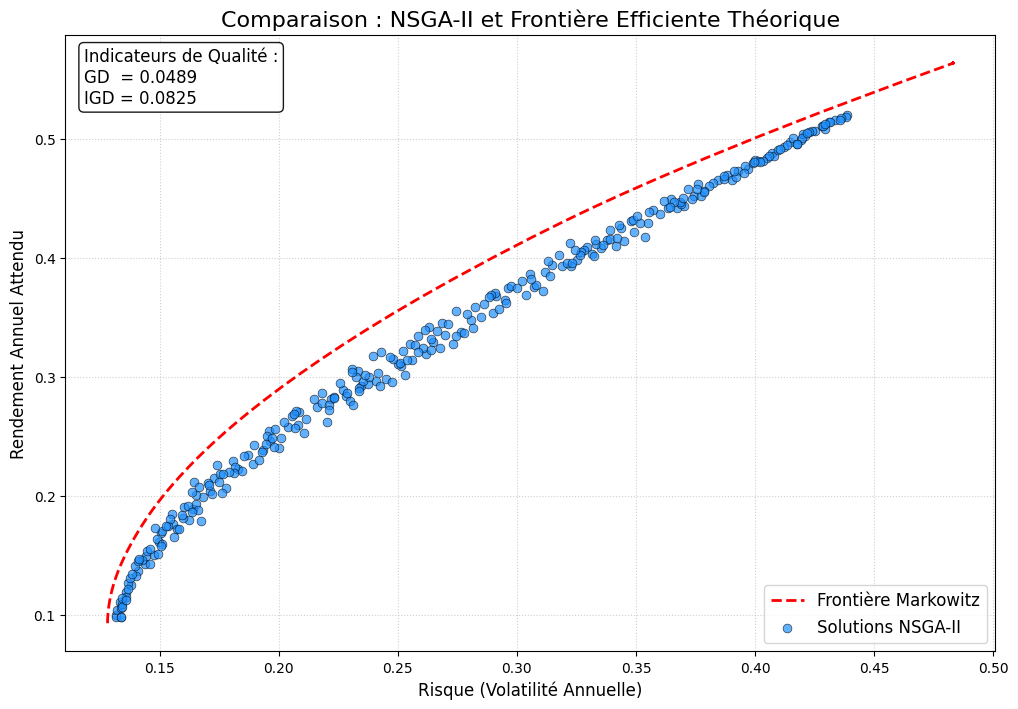

In [30]:
df_theory = pd.read_csv('frontiere_theorique_markowitz.csv')
df_theory = df_theory.sort_values(by='Volatilité')
ref_vol = df_theory['Volatilité'].values
ref_yield = df_theory['Rendement'].values
approx_vol = frontier_volatility
approx_yield = frontier_yields

pf_ref = np.column_stack([ref_vol, -ref_yield])
pf_approx = np.column_stack([approx_vol, -approx_yield])

# Normalisation [0,1] basée sur les extrêmes théoriques
min_val = pf_ref.min(axis=0)
max_val = pf_ref.max(axis=0)
norm_range = max_val - min_val
pf_ref_norm = (pf_ref - min_val) / norm_range
pf_approx_norm = (pf_approx - min_val) / norm_range

score_gd = GD(pf_ref_norm)(pf_approx_norm)
score_igd = IGD(pf_ref_norm)(pf_approx_norm)

print(f"Indicateur de qualité")
print(f"Generational Distance (GD) : {score_gd:.6f} (Proximité)")
print(f"Inverted GD (IGD)          : {score_igd:.6f} (Diversité)")

plt.figure(figsize=(12, 8))
plt.plot(ref_vol, ref_yield, color='red', linestyle='--', linewidth=2, label='Frontière Markowitz')
plt.scatter(approx_vol, approx_yield, color='dodgerblue', alpha=0.7, s=40, edgecolors='k', linewidth=0.5, label='Solutions NSGA-II')
stats_text = f"Indicateurs de Qualité :\nGD  = {score_gd:.4f}\nIGD = {score_igd:.4f}"
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
plt.title('Comparaison : NSGA-II et Frontière Efficiente Théorique', fontsize=16)
plt.xlabel('Risque (Volatilité Annuelle)', fontsize=12)
plt.ylabel('Rendement Annuel Attendu',fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [32]:
ref_point = np.array([1.1, 1.1])
ind_hv = HV(ref_point=ref_point)
score_hv = ind_hv(pf_approx_norm)
print(f"Hypervolume (HV) : {score_hv:.6f}")


Hypervolume (HV) : 0.788232
